# Feature Exploration

## Importing packages and chooing work directory

In [268]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
#from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import MinMaxScaler
import os

os.chdir("C:\\Users\\maxde\\OneDrive\\Documentos\\machine_learning\\project_1") # Change this!

## Setting up

In [269]:
database = pd.read_excel("ml_project1_data.xlsx")

seed = 101

data, data_test = train_test_split(database.copy(), test_size=0.2, stratify=database["Response"], random_state=seed)

print(data.info())
data.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1792 entries, 713 to 1559
Data columns (total 29 columns):
ID                     1792 non-null int64
Year_Birth             1792 non-null int64
Education              1792 non-null object
Marital_Status         1792 non-null object
Income                 1775 non-null float64
Kidhome                1792 non-null int64
Teenhome               1792 non-null int64
Dt_Customer            1792 non-null object
Recency                1792 non-null int64
MntWines               1792 non-null int64
MntFruits              1792 non-null int64
MntMeatProducts        1792 non-null int64
MntFishProducts        1792 non-null int64
MntSweetProducts       1792 non-null int64
MntGoldProds           1792 non-null int64
NumDealsPurchases      1792 non-null int64
NumWebPurchases        1792 non-null int64
NumCatalogPurchases    1792 non-null int64
NumStorePurchases      1792 non-null int64
NumWebVisitsMonth      1792 non-null int64
AcceptedCmp3           179

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
713,1044,1953,Graduation,Together,58398.0,0,0,2013-05-14,44,299,...,4,0,0,0,0,0,0,3,11,0
1390,8216,1972,Master,Married,53761.0,1,1,2013-10-11,7,158,...,5,0,0,0,0,0,0,3,11,0
1352,8369,1987,Graduation,Together,18227.0,1,0,2012-11-08,21,1,...,8,0,0,0,0,0,0,3,11,0
179,6935,1951,2n Cycle,Married,78497.0,0,0,2013-12-01,44,207,...,2,0,0,0,1,0,0,3,11,0
975,10286,1962,Graduation,Married,83715.0,0,0,2014-02-03,2,318,...,0,0,0,0,0,0,0,3,11,0


# 1. Exploring Data
## 1.1 Missings

In [270]:
# Receives a dataframe and returns a table with missing values count, perentage and flag for higher than 3%.
def missing_rep(df):
    miss = df.isna().sum()
    miss = miss[miss>0]
    miss_p = miss/df.shape[0]
    miss_t = miss_p>0.03

    return pd.DataFrame({"Missings" : miss, "Proportion of Missings" : miss_p, "Higher than 3%" : miss_t})



missing_rep(data)

,Missings,Proportion of Missings,Higher than 3%
Income,17,0.009487,False


These missings will be dealt with further into our exploration.

## 1.2 Categorical Variables Analysis

#### The average response rate is almost 15%.

In [271]:
data["Response"].mean() # 15%

0.14899553571428573

#### Descriptive table of categorial features

In [272]:
# List of categorical features:
feat_c = ["Education", "Marital_Status", "Kidhome", "Teenhome", "AcceptedCmp1", "AcceptedCmp2", "AcceptedCmp3", "AcceptedCmp4",
         "AcceptedCmp5", "Complain"]



# Receives dataframe, list of categorical features names(can be just 1), targer variable name,
# number of minimu observations to be taken into account and threshold of discrimination ability and
# returns a table with descriptive stats about these categorical features.
def cat_feat_describe(df, fc, target, n, thresh):

    fl = []
    
    
    
    if (type(fc)==list):
    
        for feature in fc:
            fl.append(df.groupby([feature]).agg({target : ["count", "mean"]}))    

            fm = pd.concat(fl, keys=fc)

            fm = pd.DataFrame({"Number of observations" : fm.iloc[:,0], "Discrimination ability" : fm.iloc[:,1],
                                 "More than n observations" : fm.iloc[:,0]>n,
                                 "Higher discrimination ability than the Threshold" : fm.iloc[:,1]>thresh,
                                 "Both True" : ((fm.iloc[:,0]>n) & (fm.iloc[:,1]>thresh))})
    else:
        fm = (df.groupby(fc).agg({target : ["count", "mean"]}))
        
        fm = pd.DataFrame({"Number of observations" : fm.iloc[:,0], "Discrimination ability" : fm.iloc[:,1],
                                 "More than n observations" : fm.iloc[:,0]>n,
                                 "Higher discrimination ability than the Threshold" : fm.iloc[:,1]>thresh,
                                 "Both True" : ((fm.iloc[:,0]>n) & (fm.iloc[:,1]>thresh))})
        
    return fm






feat_sum = cat_feat_describe(data, feat_c, "Response", 40, 0.15)
feat_sum

Number of observations  Discrimination ability  \
Education      2n Cycle                       160                0.106250   
               Basic                           39                0.025641   
               Graduation                     919                0.133841   
               Master                         294                0.156463   
               PhD                            380                0.210526   
Marital_Status Absurd                           1                1.000000   
               Alone                            3                0.333333   
               Divorced                       186                0.220430   
               Married                        692                0.109827   
               Single                         376                0.223404   
               Together                       468                0.096154   
               Widow                           64                0.281250   
               YOLO                             2                0.500000   
Kidhome        0                             1042                0.168906   
               1                              706                0.126062   
               2                               44                0.045455   
Teenhome       0                              901                0.205327   
               1                              844                0.091232   
               2                               47                0.106383   
AcceptedCmp1   0                             1682                0.123068   
               1                              110                0.545455   
AcceptedCmp2   0                             1769                0.142453   
               1                               23                0.652174   
AcceptedCmp3   0                             1664                0.124399   
               1                              128                0.468750   
AcceptedCmp4   0                             1660                0.129518   
               1                              132                0.393939   
AcceptedCmp5   0                             1665                0.118318   
               1                              127                0.551181   
Complain       0                             1775                0.148732   
               1                               17                0.176471   

                           More than n observations  \
Education      2n Cycle                        True   
               Basic                          False   
               Graduation                      True   
               Master                          True   
               PhD                             True   
Marital_Status Absurd                         False   
               Alone                          False   
               Divorced                        True   
               Married                         True   
               Single                          True   
               Together                        True   
               Widow                           True   
               YOLO                           False   
Kidhome        0                               True   
               1                               True   
               2                               True   
Teenhome       0                               True   
               1                               True   
               2                               True   
AcceptedCmp1   0                               True   
               1                               True   
AcceptedCmp2   0                               True   
               1                              False   
AcceptedCmp3   0                               True   
               1                               True   
AcceptedCmp4   0                               True   
               1                               True   
AcceptedCmp5   0      

#### These states of these classes show both decent number of observations and a discrimination ability higher than 15%.

In [273]:
feat_sum[feat_sum["Both True"]]

Number of observations  Discrimination ability  \
Education      Master                       294                0.156463   
               PhD                          380                0.210526   
Marital_Status Divorced                     186                0.220430   
               Single                       376                0.223404   
               Widow                         64                0.281250   
Kidhome        0                           1042                0.168906   
Teenhome       0                            901                0.205327   
AcceptedCmp1   1                            110                0.545455   
AcceptedCmp3   1                            128                0.468750   
AcceptedCmp4   1                            132                0.393939   
AcceptedCmp5   1                            127                0.551181   

                         More than n observations  \
Education      Master                        True   
               PhD                           True   
Marital_Status Divorced                      True   
               Single                        True   
               Widow                         True   
Kidhome        0                             True   
Teenhome       0                             True   
AcceptedCmp1   1                             True   
AcceptedCmp3   1                             True   
AcceptedCmp4   1                             True   
AcceptedCmp5   1                             True   

                         Higher discrimination ability than the Threshold  \
Education      Master                                                True   
               PhD                                                   True   
Marital_Status Divorced                                              True   
               Single                                                True   
               Widow                                                 True   
Kidhome        0                                                     True   
Teenhome       0                                                     True   
AcceptedCmp1   1                                                     True   
AcceptedCmp3   1                                                     True   
AcceptedCmp4   1                                                     True   
AcceptedCmp5   1                                                     True   

                         Both True  
Education      Master         True  
               PhD            True  
Marital_Status Divorced       True  
               Single         True  
               Widow          True  
Kidhome        0              True  
Teenhome       0              True  
AcceptedCmp1   1              True  
AcceptedCmp3   1              True  
AcceptedCmp4   1              True  
AcceptedCmp5   1              True

#### States of classes with few observations

We can observe that there are three status of the categorial variable Marital_Status that hold few observations while not fitting into the common marital status we know. We should remove these observations.

In [274]:
feat_sum[-feat_sum["More than n observations"]]

Number of observations  Discrimination ability  \
Education      Basic                       39                0.025641   
Marital_Status Absurd                       1                1.000000   
               Alone                        3                0.333333   
               YOLO                         2                0.500000   
AcceptedCmp2   1                           23                0.652174   
Complain       1                           17                0.176471   

                       More than n observations  \
Education      Basic                      False   
Marital_Status Absurd                     False   
               Alone                      False   
               YOLO                       False   
AcceptedCmp2   1                          False   
Complain       1                          False   

                       Higher discrimination ability than the Threshold  \
Education      Basic                                              False   
Marital_Status Absurd                                              True   
               Alone                                               True   
               YOLO                                                True   
AcceptedCmp2   1                                                   True   
Complain       1                                                   True   

                       Both True  
Education      Basic       False  
Marital_Status Absurd      False  
               Alone       False  
               YOLO        False  
AcceptedCmp2   1           False  
Complain       1           False

In [275]:
data_ = data.copy()

strange_cat = ["Absurd", "Alone", "YOLO"]
for cat in strange_cat:
    data_ = data_[data_.Marital_Status != cat]

In [276]:
data_.groupby("Marital_Status").count().index

Index(['Divorced', 'Married', 'Single', 'Together', 'Widow'], dtype='object', name='Marital_Status')

#### Visualization of Discrimination Ability of Categorical Features

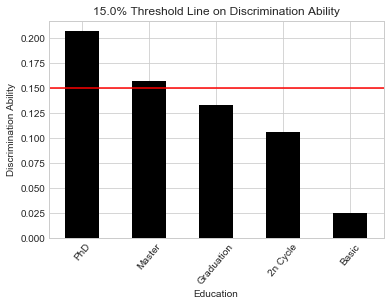

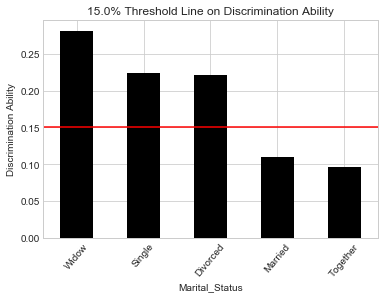

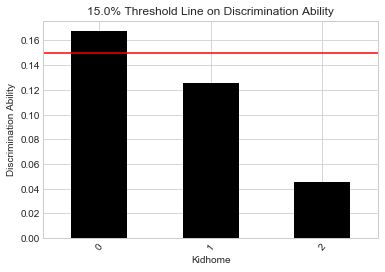

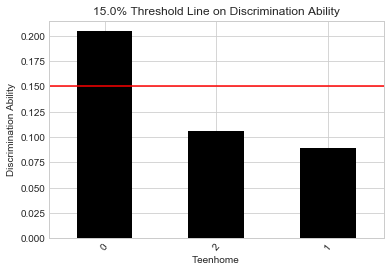

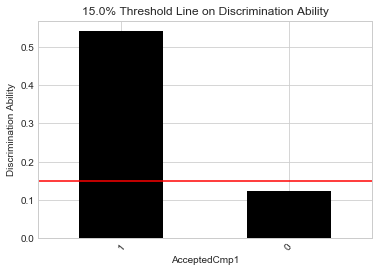

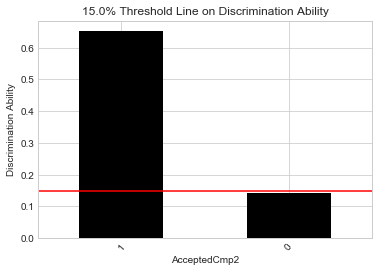

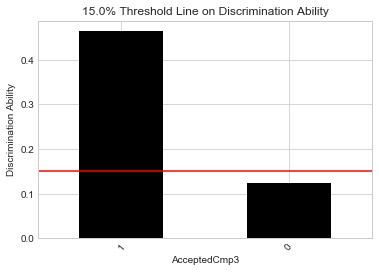

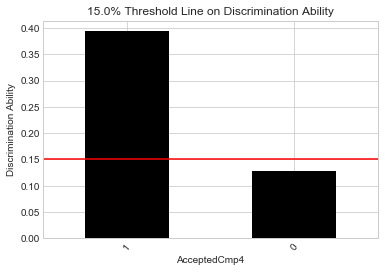

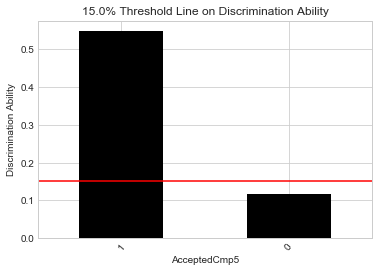

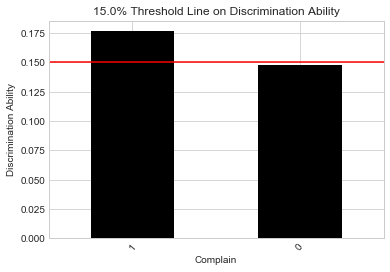

In [277]:
# Takes a dataframe, list of categorical features names (can be 1), the target variable name
# and the trheshold of discrimination ability and outputs all plots.
def cat_feat_plot(df, fc, target, thresh):

    sns.set_style("whitegrid")

    if (type(fc)==str):
        plot_df = cat_feat_describe(df, fc, target, 50, thresh).iloc[:,1]

        plot_df = plot_df.sort_values(ascending=False)

        ax = plot_df.plot.bar(color="black", title="{}% Threshold Line on Discrimination Ability".format(thresh*100), legend=False)
        ax.set_ylabel("Discrimination Ability", size = 10)
        ax.axhline(y=thresh, color="red")
        ax.set_xticklabels(plot_df.index, rotation=50, size=10)


        plt.show()
        
        
        
    else:
        for feat in fc:
            plot_df = cat_feat_describe(df, feat, target, 50, thresh).iloc[:,1]

            plot_df = plot_df.sort_values(ascending=False)

            
            ax = plot_df.plot.bar(color="black", title="{}% Threshold Line on Discrimination Ability".format(thresh*100), legend=False)
            ax.set_ylabel("Discrimination Ability", size = 10)
            ax.axhline(y=thresh, color="red")
            ax.set_xticklabels(plot_df.index, rotation=50, size=10)

            plt.show()
        
        
        
        
        
    
cat_feat_plot(data_, feat_c, "Response", 0.15)

## 1.3 Numerical Variables Analysis

#### Dt_Customer into days since registration

In [278]:
# Gets a series of dates and its format as parameters and returns a series of days since that date until today.
def days_since(dates_series, date_format):

    n = len(dates_series)
    
    result = [0] * n

    for i in range(n):
        result[i] = (datetime.today()-datetime.strptime(dates_series[i], date_format)).days
    
    return result



data_["Days_Customer"] = days_since(list(data_.Dt_Customer), "%Y-%m-%d")

data_ = data_.drop(columns="Dt_Customer")

data_["Days_Customer"].head()

713     2151
1390    2001
1352    2338
179     1950
975     1886
Name: Days_Customer, dtype: int64

In [279]:
feat_n = list(data_.columns)

feat_n = list(filter(lambda x: x not in feat_c, feat_n))

feat_n.remove("ID") # Removing ID.
# List of Numerical Variables

data_[feat_n].describe() # Describing only Numerical Variables

,Year_Birth,Income,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Z_CostContact,Z_Revenue,Response,Days_Customer
count,1786.000000,1769.000000,1786.000000,1786.000000,1786.000000,1786.000000,1786.000000,1786.000000,1786.000000,1786.000000,1786.000000,1786.000000,1786.000000,1786.000000,1786.0,1786.0,1786.000000,1786.000000
mean,1968.987682,52143.137931,48.858903,303.129339,25.293393,164.729003,36.800672,26.647816,43.907615,2.332027,4.119821,2.661254,5.798992,5.334826,3.0,11.0,0.147816,2098.015118
std,11.759583,25943.131180,29.199732,334.183213,38.112103,223.012043,53.682024,40.482880,52.127326,1.916186,2.818144,2.953615,3.247480,2.410502,0.0,0.0,0.355017,202.925399
min,1899.000000,2447.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000,1740.000000
25%,1960.000000,35246.000000,24.000000,24.000000,1.250000,16.000000,3.000000,1.000000,9.000000,1.000000,2.000000,0.000000,3.000000,3.000000,3.0,11.0,0.000000,1924.250000
50%,1970.000000,51315.000000,49.000000,174.500000,8.000000,66.500000,12.000000,9.000000,24.500000,2.000000,4.000000,2.000000,5.000000,6.000000,3.0,11.0,0.000000,2101.000000
75%,1977.000000,68148.000000,74.000000,504.750000,31.000000,230.000000,50.000000,32.750000,56.000000,3.000000,6.000000,4.000000,8.000000,7.000000,3.0,11.0,0.000000,2273.000000
max,1995.000000,666666.000000,99.000000,1492.000000,199.000000,1725.000000,259.000000,263.000000,362.000000,15.000000,27.000000,28.000000,13.000000,20.000000,3.0,11.0,1.000000,2439.000000


#### Variables with zero variance (constants)

In [280]:
std = data_[feat_n].describe().iloc[2,:]
std[std<0.05]

Z_CostContact    0.0
Z_Revenue        0.0
Name: std, dtype: float64

#### Removing constant variables

In [281]:
const = [std[std<0.05].index[0], std[std<0.05].index[1]]

data_.drop(labels=const, axis=1, inplace=True) # Now data_ does not contain zero variance variables.


feat_n = list(filter(lambda x: x not in const, feat_n)) # Removing the names of the no varaiance variables
                                                        # from the list of numerical features.

## Inputing Missing Values
Instead of a simple mean inputation, we employ the Linear Regression model from sklearn package to perform a prediction of what the missing values in Income would be considering all the other variables and use it to input the missing values.

In [284]:
# Preparing all datasets to be used in the Linear Regression Model
X = data_
y = X["Income"]
y = y[-y.isna()]
X = X.drop(columns=["ID"])


X["Marital_Status"] = pd.Categorical(X["Marital_Status"])
X["Marital_Status"] = X["Marital_Status"].cat.codes

X["Education"] = pd.Categorical(X["Education"])
X["Education"] = X["Education"].cat.codes

x_pred = X[X.Income.isna()]
x_pred = x_pred.drop(columns="Income")

X = X[-X.Income.isna()]
X = X.drop(columns="Income")





# Linear Regression Model
reg = LinearRegression().fit(X, y)

# Predictions
y_pred = reg.predict(x_pred)

# Store the predictions in the missing values
data_.loc[data_.Income.isna(), "Income"] = y_pred

In [285]:
missing_rep(data_) # No more missings!

,Missings,Proportion of Missings,Higher than 3%


#### Correlation Matrix between numerical variables


We employ the correlation matrix here in order to find variables that show high correlation between them so we could eliminate one or join them.

In [286]:
# The function to "zoom" in the correlation matrix.
def magnify():
    return [dict(selector="th",
                 props=[("font-size", "7pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "12pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '12pt')])]



# Takes a dataframe and returns the correlation matrix while plotting the correlation matrix plot using hues of blue and red.
def corr_matrix(df):
    # Compute the correlation matrix
    corr = df.corr()

    cmap = sns.diverging_palette(5, 250, as_cmap=True)


    vis = corr.style.background_gradient(cmap, axis=1)\
            .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
            .set_caption("Hover to magify")\
            .set_precision(2)\
            .set_table_styles(magnify())

    return vis




feat_n_ = feat_n.copy()
feat_n_.remove("Response") # Removing the Targer variable from the list of numerical features to be analyzed by correlation.
corr_matrix(data_[feat_n_])

,Year_Birth,Income,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Days_Customer
Year_Birth,1,-0.14,-0.013,-0.16,-0.032,-0.02,-0.031,-0.018,-0.078,-0.076,-0.14,-0.11,-0.12,0.11,0.015
Income,-0.14,1,-0.012,0.56,0.41,0.57,0.43,0.43,0.3,-0.053,0.37,0.57,0.51,-0.54,-0.023
Recency,-0.013,-0.012,1,-0.00086,-0.002,0.027,-0.00023,0.031,0.021,0.004,-0.009,0.02,-0.01,-0.012,0.039
MntWines,-0.16,0.56,-0.00086,1,0.39,0.56,0.4,0.39,0.39,0.031,0.54,0.62,0.64,-0.33,0.15
MntFruits,-0.032,0.41,-0.002,0.39,1,0.55,0.6,0.55,0.39,-0.12,0.3,0.47,0.46,-0.42,0.075
MntMeatProducts,-0.02,0.57,0.027,0.56,0.55,1,0.56,0.53,0.33,-0.093,0.3,0.74,0.49,-0.53,0.096
MntFishProducts,-0.031,0.43,-0.00023,0.4,0.6,0.56,1,0.59,0.4,-0.15,0.3,0.52,0.45,-0.44,0.075
MntSweetProducts,-0.018,0.43,0.031,0.39,0.55,0.53,0.59,1,0.39,-0.12,0.36,0.48,0.44,-0.43,0.086
MntGoldProds,-0.078,0.3,0.021,0.39,0.39,0.33,0.4,0.39,1,0.055,0.43,0.41,0.37,-0.23,0.16
NumDealsPurchases,-0.076,-0.053,0.004,0.031,-0.12,-0.093,-0.15,-0.12,0.055,1,0.24,0.021,0.083,0.31,0.23


In [287]:
# Function to find the maximum value in a correlation matrix and print the line and column it is located.
def max_matrix(matrix):

    aux = 0
    line = ""
    col = ""
    for l in matrix:
        for i in matrix:
            if ((matrix[l][i]<1) & (abs(matrix[l][i])>abs(aux))):
                aux = matrix[l][i]
                line = l
                col = i


    print("Max Value:", aux,
          "\nLine:", line,
          "\nColumn:", col)


    return aux


max_matrix(data_[feat_n_].corr())

Max Value: 0.7379044410395943 
Line: MntMeatProducts 
Column: NumCatalogPurchases


0.7379044410395943

The highest correlation we have is between number of Meat PRoducst purchased and number of Catalog Purchases (0,74).

#### Visualization of Numerical Variables

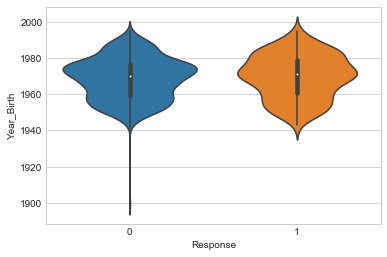

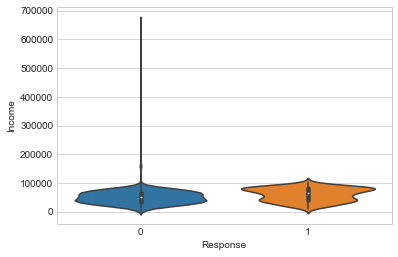

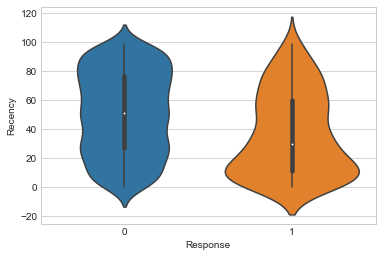

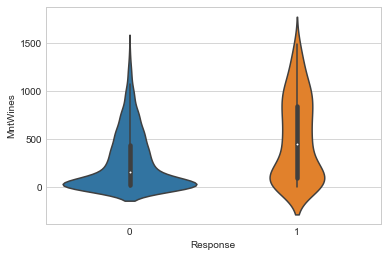

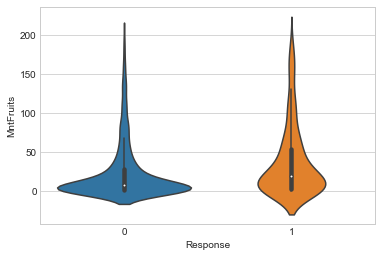

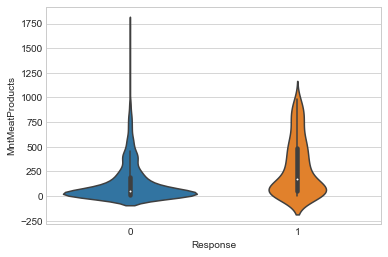

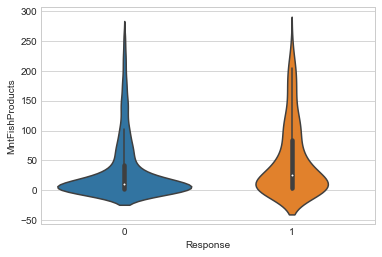

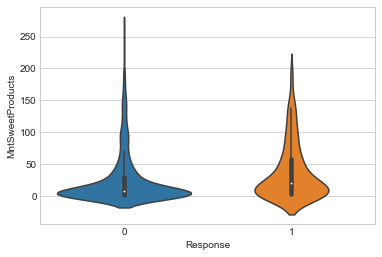

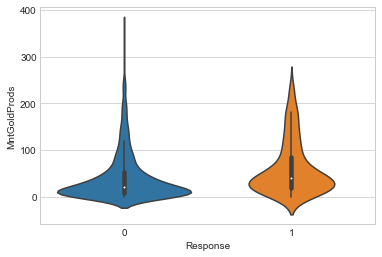

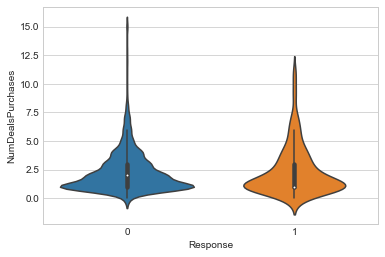

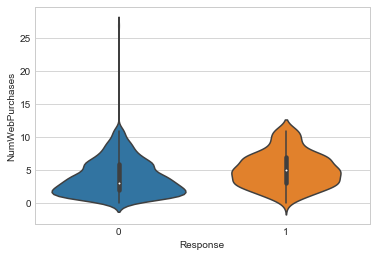

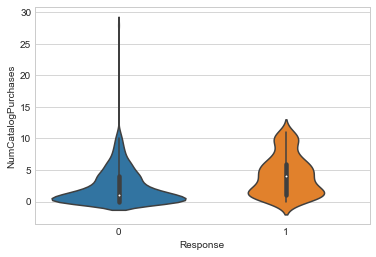

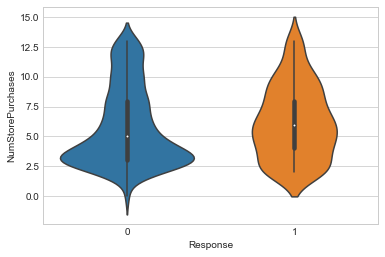

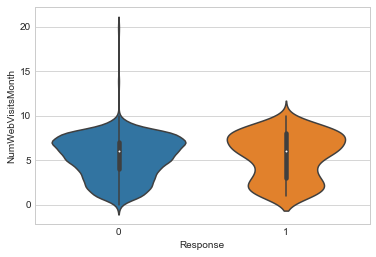

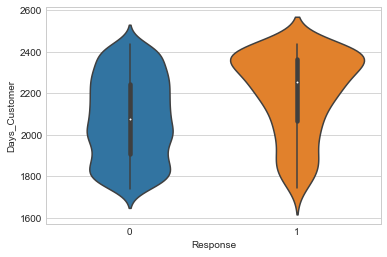

In [288]:
# Can give from 1 to all of numeric features a feat_n.
# Can give a categorical feature to be used (optional).
def num_feat_plot(df, feat_nlist, target, feat_clist = None):
    
    if(target in feat_nlist):
        feat_nl = feat_nlist.copy()
        feat_nl.remove(target)
    
    if (feat_clist==None):
        
        if (type(feat_nl)==str):
            
            sns.violinplot(data = df, y = feat_nl, x = target)
            plt.show()
            
            
        else:
            for feat in feat_nl:
                sns.violinplot(data = df, y = feat, x = target)
                plt.show()
        
    else:
        if (type(feat_nl)==str):
            
            sns.violinplot(data = data_, y = feat_nl, x = feat_clist, hue = target)
            plt.show()
            
            
        else:
            for feat in feat_nl:
                sns.violinplot(data = data_, y = feat, x = feat_clist, hue = target)
                plt.show()
                
    return

num_feat_plot(data_, feat_n, "Response")

It is clear that Income holds many high outliers, while Year_Birth holds low outliers. Some of the number of purchases variables also show high outliers.

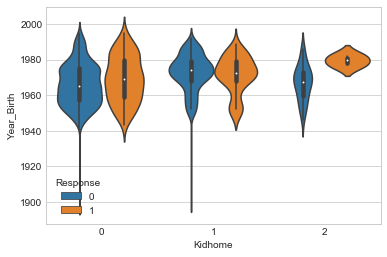

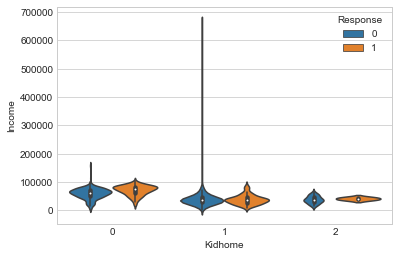

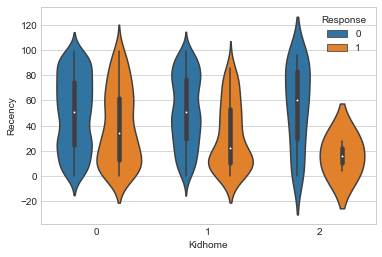

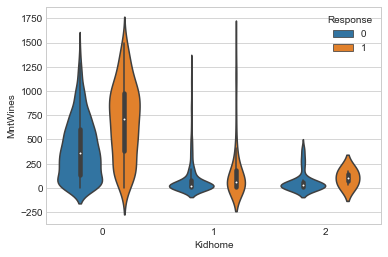

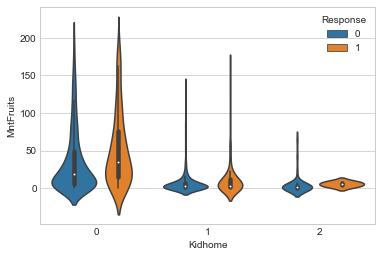

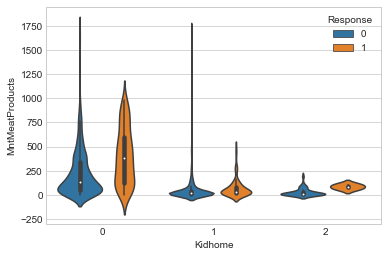

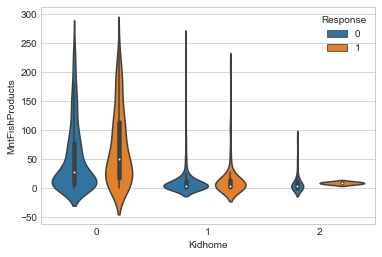

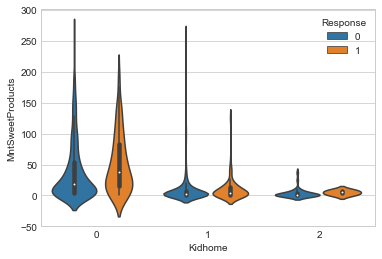

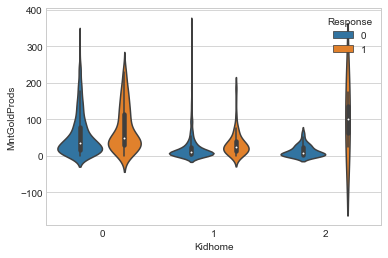

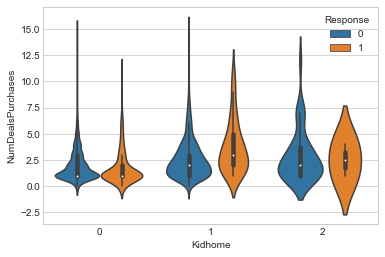

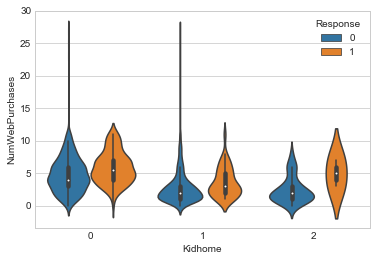

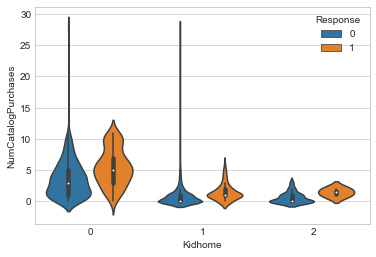

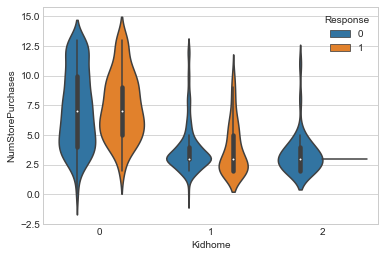

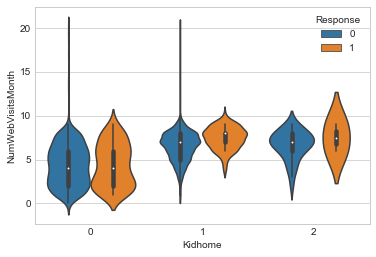

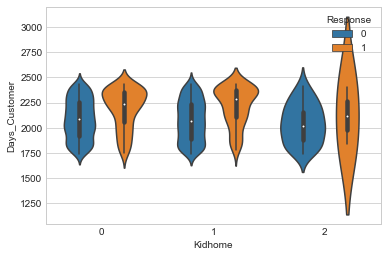

In [289]:
num_feat_plot(data_, feat_n, "Response", "Kidhome")

## 1.4 Outlier Detection

#### Univariate Outliers


In [290]:
def filter_by_std(series_, n_stdev=3.0, return_thresholds=False):
    mean_, stdev_ = series_.mean(), series_.std()
    cutoff = stdev_ * n_stdev
    lower_bound, upper_bound = mean_ - cutoff, mean_ + cutoff
    if return_thresholds:
        return lower_bound, upper_bound
    else:
        return [True if i < lower_bound or i > upper_bound else False for i in series_]
    
def filter_by_iqr(series_, k=1.5, return_thresholds=False):
    q25, q75 = np.percentile(series_, 25), np.percentile(series_, 75)
    iqr = q75-q25
    
    cutoff = iqr*k
    lower_bound, upper_bound = q25-cutoff, q75+cutoff
    
    if return_thresholds:
        return lower_bound, upper_bound
    else:
        return [True if i < lower_bound or i > upper_bound else False for i in series_]

In [291]:
outliers = pd.DataFrame(data_.iloc[1:2,:])

for feat in feat_n:
    outliers = outliers.append(data_[filter_by_std(data_[feat], n_stdev=3)])
    
outliers = outliers.drop(outliers.index[0])


outliers
#data_[filter_by_std(data_[feat_n[3]], n_stdev=3)]

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,...,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Days_Customer
339,1150,1899,PhD,Together,83532.000000,0,0,36,755,144,...,4,1,0,0,1,0,0,0,0,2016
192,7829,1900,2n Cycle,Divorced,36640.000000,1,0,99,15,6,...,2,5,0,0,0,0,0,1,0,2016
2233,9432,1977,Graduation,Together,666666.000000,1,0,23,9,14,...,3,6,0,0,0,0,0,0,0,2132
164,8475,1973,PhD,Married,157243.000000,0,1,98,20,2,...,0,0,0,0,0,0,0,0,0,1860
1653,4931,1977,Graduation,Together,157146.000000,0,0,13,1,0,...,0,1,0,0,0,0,0,0,0,2166
1300,5336,1971,Master,Together,157733.000000,1,0,37,39,1,...,1,1,0,0,0,0,0,0,0,2130
617,1503,1976,PhD,Together,162397.000000,1,1,31,85,1,...,1,1,0,0,0,0,0,0,0,2131
687,1501,1982,PhD,Married,160803.000000,0,0,21,55,16,...,1,0,0,0,0,0,0,0,0,2434
543,5547,1982,PhD,Married,84169.000000,0,0,9,1478,19,...,6,3,0,1,1,0,0,0,1,2066
987,4580,1969,Graduation,Married,75759.000000,0,0,46,1394,22,...,9,5,1,0,1,1,0,0,1,1987


In [292]:
feat_n

['Year_Birth',
 'Income',
 'Recency',
 'MntWines',
 'MntFruits',
 'MntMeatProducts',
 'MntFishProducts',
 'MntSweetProducts',
 'MntGoldProds',
 'NumDealsPurchases',
 'NumWebPurchases',
 'NumCatalogPurchases',
 'NumStorePurchases',
 'NumWebVisitsMonth',
 'Response',
 'Days_Customer']

#### Mahalanobis Distant to find Multivariate Outliers
The Euclidian distance is known to fail to find outliers when dealing with multi dimensional data. So we use the Mahalanobis Distance, because, since it uses the Eigenvalues of the variables instead of the original axis, it can make something similar to a feature scaling.

With these functions we can find the rows which represent multivariate outliers. The only path to take from this is removing these rows, as opposed to inputing the extreme values, like when we are dealing with univariate outliers.

In [185]:
# Simple function to check if the matrix is positive definite (for example, it will return False if the matrix contains NaN).
def is_pos_def(A):
    if np.allclose(A, A.T):
        try:
            np.linalg.cholesky(A)
            return True
        except np.linalg.LinAlgError:
            return False
    else:
        return False 

    
    
    
    
    
# The function to calculate the Mahalanobis Distance. Returns a list of distances.
def MahalanobisDist(data):
    covariance_matrix = np.cov(data, rowvar=False)
    if is_pos_def(covariance_matrix):
        inv_covariance_matrix = np.linalg.inv(covariance_matrix)
        if is_pos_def(inv_covariance_matrix):
            vars_mean = []
            for i in range(data.shape[0]):
                vars_mean.append(list(data.mean(axis=0)))
            diff = data - vars_mean
            md = []
            for i in range(len(diff)):
                md.append(np.sqrt(diff[i].dot(inv_covariance_matrix).dot(diff[i])))
            return md
        else:
            print("Error: Inverse of Covariance Matrix is not positive definite!")
    else:
        print("Error: Covariance Matrix is not positive definite!")

        
        
        
        
# Function to detect multivariate outliers from the Mahalanobis Distances. Returns an array of indexes of the outliers.    
def MD_detectOutliers(data, extreme=False):
    MD = MahalanobisDist(data)

    std = np.std(MD)
    k = 3. * std if extreme else 2. * std
    m = np.mean(MD)
    up_t = m + k
    low_t = m - k
    outliers = []
    for i in range(len(MD)):
        if (MD[i] >= up_t) or (MD[i] <= low_t):
            outliers.append(i)  # index of the outlier
    return np.array(outliers)


In [186]:
# Here we are creating an auxiliar dataframe and inputing NaN with the mean so we can calculate the Mahalanobis Distances.
data_aux = data_[feat_n_]

data_aux = data_aux.apply(lambda x: x.fillna(x.mean()), axis=0)

In [187]:
# Run the function
outliers_i = MD_detectOutliers(np.array(data_aux))
len(outliers_i)

30

These observations were detected as multivariate outliers by the Mahalanobis Distance method.

We could simply remove these rows from the dataset, since only 30 outlier observations were detected.

In [201]:
# Rows which were detected as multivariate outliers:
dat = pd.DataFrame()
for i in outliers_i:
    dat = dat.append(data_aux.iloc[i,:])
    
dat

,Days_Customer,Income,MntFishProducts,MntFruits,MntGoldProds,MntMeatProducts,MntSweetProducts,MntWines,NumCatalogPurchases,NumDealsPurchases,NumStorePurchases,NumWebPurchases,NumWebVisitsMonth,Recency,Year_Birth
1808,1802.0,90369.00000,224.0,51.0,17.0,981.0,23.0,292.0,6.0,1.0,6.0,4.0,1.0,2.0,1956.0
2233,2132.0,666666.00000,8.0,14.0,12.0,18.0,1.0,9.0,1.0,4.0,3.0,3.0,6.0,23.0,1977.0
1010,2413.0,77568.00000,232.0,0.0,158.0,396.0,178.0,1230.0,2.0,1.0,8.0,10.0,5.0,30.0,1979.0
1641,2019.0,64140.00000,0.0,0.0,215.0,61.0,15.0,1459.0,5.0,5.0,6.0,2.0,5.0,71.0,1964.0
2168,1928.0,90000.00000,94.0,144.0,241.0,133.0,192.0,675.0,8.0,1.0,5.0,4.0,1.0,91.0,1984.0
1480,2194.0,60474.00000,234.0,199.0,170.0,303.0,9.0,265.0,2.0,7.0,12.0,10.0,7.0,25.0,1979.0
528,2426.0,61839.00000,224.0,155.0,120.0,379.0,17.0,1000.0,8.0,1.0,4.0,4.0,8.0,20.0,1964.0
164,1860.0,157243.00000,1.0,2.0,1.0,1582.0,2.0,20.0,22.0,15.0,0.0,0.0,0.0,98.0,1973.0
432,2262.0,67309.00000,149.0,47.0,95.0,181.0,95.0,515.0,6.0,15.0,9.0,9.0,7.0,76.0,1967.0
1653,2166.0,157146.00000,2.0,0.0,1.0,1725.0,1.0,1.0,28.0,0.0,0.0,0.0,1.0,13.0,1977.0


In [ ]:
def chisq_ranker(df, continuous_flist, categorical_flist, target, n_bins=10, binning_strategy="uniform"):
    chisq_dict = {}
    if  continuous_flist:
        bindisc = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', 
                               strategy=binning_strategy)
        for feature in continuous_flist:            
            feature_bin = bindisc.fit_transform(df[feature].values[:, np.newaxis])
            feature_bin = pd.Series(feature_bin[:, 0], index=df.index)
            cont_tab = pd.crosstab(feature_bin, df[target], margins = False)
            chisq_dict[feature] = stats.chi2_contingency(cont_tab.values)[0:2] 
    if  categorical_flist:
        for feature in categorical_flist:  
            cont_tab = pd.crosstab(df[feature], df[target], margins = False)          
            chisq_dict[feature] = stats.chi2_contingency(cont_tab.values)[0:2]       
    
    return chisq_dict